In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import json 


In [3]:
video_games_df = pd.read_csv('video_games_df_final.csv')

In [4]:
imputer = SimpleImputer(strategy='mean')
video_games_df['critic_score'] = imputer.fit_transform(video_games_df[['critic_score']])

# Convert categorical variables to one-hot encoding
cat_columns = ['console', 'genre', 'publisher', 'developer']
video_games_df = pd.get_dummies(video_games_df, columns=cat_columns, drop_first=True)

# Identify numerical columns to scale
num_columns = ['critic_score', 'niche_count', 'na_sales_avg_temp', 'jp_sales_avg_temp', 
               'pal_sales_avg_temp', 'special_sales_day_count', 'days_since_release']

# Standardize the numerical features
scaler = StandardScaler()
video_games_df[num_columns] = scaler.fit_transform(video_games_df[num_columns])

In [93]:
video_games_df_2 = pd.read_csv('video_games_df_final.csv')
imputer = SimpleImputer(strategy='mean')
video_games_df_2['critic_score'] = imputer.fit_transform(video_games_df_2[['critic_score']])
# Identify numerical columns to scale
num_columns = ['critic_score', 'niche_count', 'na_sales_avg_temp', 'jp_sales_avg_temp', 
               'pal_sales_avg_temp', 'special_sales_day_count', 'days_since_release']

# Standardize the numerical features
scaler = StandardScaler()
video_games_df_2[num_columns] = scaler.fit_transform(video_games_df_2[num_columns])

# Post Matching Functions

In [38]:
def cate(matches, months):
    cate_dict = {month: {m: [] for m in months[s + 1:]} for s, month in enumerate(months[:-1])}
    
    for start, month in enumerate(months[:-1]):
        for other_month in months[start + 1:]:
            relevant_matches = matches[month][other_month]
            cate_list = []
            for i in range(len(relevant_matches['current_sales'])):
                unit_sales = relevant_matches['current_sales'][i]
                matched_sales = relevant_matches['matched_sales'][i]
                mean_y = np.mean(matched_sales)
                cate_list.append(unit_sales - mean_y)
            cate_dict[month][other_month] = np.mean(cate_list)
            
    return cate_dict


def print_ates(cate_dict):
    for month, other_months in cate_dict.items():
        for other_month, cate_list in other_months.items():
            ate = np.mean(cate_list)
            print(f"ATE from {month} to {other_month}: {ate}")
            

In [57]:
import numpy as np

def bootstrap_cate_with_p_value(matches, months, num_bootstrap=1000, confidence_level=0.95):
    cate_results = {}
    cate_conf_intervals = {}
    p_values = {}

    for start, month in enumerate(months[:-1]):
        for other_month in tqdm(months[start + 1:]):
            # Get the relevant matches for the month pair
            relevant_matches = matches[month][other_month]
            unit_sales = relevant_matches['current_sales']
            matched_sales = relevant_matches['matched_sales']

            # Calculate observed CATE (using corrected logic)
            cate_list = []
            for i in range(len(unit_sales)):
                mean_y = np.mean(matched_sales[i])  # Calculate mean matched sales
                cate_list.append(unit_sales[i] - mean_y)
            observed_cate = np.mean(cate_list)
            cate_results.setdefault(month, {})[other_month] = observed_cate

            # Bootstrap CATEs
            bootstrap_cates = []
            for _ in range(num_bootstrap):
                # Resample indices with replacement
                resample_indices = np.random.choice(len(unit_sales), size=len(unit_sales), replace=True)
                resampled_unit_sales = unit_sales[resample_indices]
                resampled_matched_sales = matched_sales[resample_indices]
                
                # Calculate CATE for this bootstrap sample (using corrected logic)
                bootstrap_cate_list = []
                for i in range(len(resampled_unit_sales)):
                    mean_y = np.mean(resampled_matched_sales[i])
                    bootstrap_cate_list.append(resampled_unit_sales[i] - mean_y)
                bootstrap_cate = np.mean(bootstrap_cate_list)
                bootstrap_cates.append(bootstrap_cate)

            # Confidence intervals for bootstrap CATE
            alpha = 1 - confidence_level
            lower_percentile = alpha / 2 * 100
            upper_percentile = (1 - alpha / 2) * 100
            ci_lower = np.percentile(bootstrap_cates, lower_percentile)
            ci_upper = np.percentile(bootstrap_cates, upper_percentile)
            cate_conf_intervals.setdefault(month, {})[other_month] = (ci_lower, ci_upper)

            # Calculate two-sided p-value
            extreme_count = sum(
                abs(cate) >= abs(observed_cate) for cate in bootstrap_cates
            )
            p_value = extreme_count / num_bootstrap
            p_values.setdefault(month, {})[other_month] = p_value

    return cate_results, cate_conf_intervals, p_values



In [75]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cate_results(cate_results, cate_conf_intervals, p_values):
    # Flatten data for easier plotting
    month_pairs = []
    cates = []
    ci_lowers = []
    ci_uppers = []
    pvals = []
    
    for month in cate_results:
        for other_month in cate_results[month]:
            month_pairs.append(f"{month}-{other_month}")
            cates.append(cate_results[month][other_month])
            ci_lowers.append(cate_conf_intervals[month][other_month][0])
            ci_uppers.append(cate_conf_intervals[month][other_month][1])
            pvals.append(p_values[month][other_month])
    
    # Calculate error bars as the difference between CATE and confidence bounds
    ci_errors = [ [cate - ci_lower, ci_upper - cate] for cate, ci_lower, ci_upper in zip(cates, ci_lowers, ci_uppers)]
    ci_errors = np.array(ci_errors).T  # Transpose to separate lower and upper error bars
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Plot CATE values as dots
    plt.scatter(month_pairs, cates, color='seagreen', edgecolor='black', s=100, zorder=5)
    
    # Plot error bars (confidence intervals)
    for idx in range(len(month_pairs)):
        plt.plot([month_pairs[idx], month_pairs[idx]], [ci_lowers[idx], ci_uppers[idx]], color='black', lw=2)
    
    # Annotate significant CATEs with *
    significance_level = 0.05
    for idx in range(len(month_pairs)):
        if pvals[idx] <= significance_level:
            plt.text(month_pairs[idx], cates[idx] + max(ci_errors[:, idx]) * 0.05,
                     "*", ha='center', va='bottom', fontsize=14, color='red')
    
    # Labels and title
    plt.xlabel("Month Pairs")
    plt.ylabel("CATE")
    plt.title("CATE Results with Confidence Intervals (Significant Results Marked with *)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



In [110]:
def display_closest_matches_for_sample_latex_with_reverse(src_month, target_month, target_sample_index, closest_matches, vg_df):
    indices = closest_matches[src_month][target_month]['indices'][target_sample_index]
    # Get the closest matches for the target sample
    closest_info = []
    other_month_data = vg_df[vg_df['month'] == target_month]
    matches = other_month_data.iloc[indices.flatten()]
    current_month_data = vg_df[vg_df['month'] == target_month]
    current_data = current_month_data.iloc[target_sample_index]
    
    closest_info.append(
            {
                "Title": current_data['title'],
                "Console": current_data['console'],
                "'Genre": current_data['genre'],
                "Publisher": current_data['publisher'],
                "Developer": current_data['developer'],
                "Critic Score": current_data['critic_score'],
                "Niche Count": current_data['niche_count'],
                "NA Temperature": current_data['na_sales_avg_temp'],
                "JP Temperature": current_data['jp_sales_avg_temp'],
                "PAL Temperature": current_data['pal_sales_avg_temp'],
                "Special Sales Day Count": current_data['special_sales_day_count'],
                "Days Since Release": current_data['days_since_release'],
            }
        )
    
    for _, row in matches.iterrows():
        closest_info.append(
            {
                "Title": row['title'],
                "Console": row['console'],
                "'Genre": row['genre'],
                "Publisher": row['publisher'],
                "Developer": row['developer'],
                "Critic Score": row['critic_score'],
                "Niche Count": row['niche_count'],
                "NA Temperature": row['na_sales_avg_temp'],
                "JP Temperature": row['jp_sales_avg_temp'],
                "PAL Temperature": row['pal_sales_avg_temp'],
                "Special Sales Day Count": row['special_sales_day_count'],
                "Days Since Release": row['days_since_release'],
            }
        )
        
    
    # Convert the collected information to a DataFrame for easy display
    if closest_info:
        closest_matches_df = pd.DataFrame(closest_info)
        
        # Convert DataFrame to LaTeX
        latex_output = closest_matches_df.to_latex(index=False, escape=False)
        return latex_output
    else:
        print("No matches found for the selected sample.")
        return None

# General Matching

In [6]:
T = video_games_df['month']
y = video_games_df['total_sales']
X = video_games_df.drop(columns=['month', 'total_sales', 'img', 'na_sales', 'jp_sales', 'pal_sales',
       'other_sales', 'release_date', 'last_update', 'iso_year',
       'iso_week', 'year_week', 'title'])

In [7]:
def find_closest_matches(video_games_df, k=1):
    # Initialize an empty dictionary to store the closest matches for each month
    closest_matches = {}
    
    # List of all unique months in the data
    months = video_games_df['month'].unique()

    # Loop over each month to find closest matches from other months
    for month in months:
        # Filter data for the current month and the rest of the months
        current_month_data = video_games_df[video_games_df['month'] == month]
        other_months_data = video_games_df[video_games_df['month'] != month]
        
        # Define feature sets for KNN
        X_current = current_month_data.drop(columns=['month', 'total_sales', 'img', 'na_sales', 
                                                     'jp_sales', 'pal_sales', 'other_sales', 
                                                     'release_date', 'last_update', 'iso_year', 
                                                     'iso_week', 'year_week', 'title'])
        X_other = other_months_data.drop(columns=['month', 'total_sales', 'img', 'na_sales', 
                                                  'jp_sales', 'pal_sales', 'other_sales', 
                                                  'release_date', 'last_update', 'iso_year', 
                                                  'iso_week', 'year_week', 'title'])
        
        # Initialize and fit the KNN model
        knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
        knn.fit(X_other)
        
        # Find k closest matches for each entry in the current month
        distances, indices = knn.kneighbors(X_current)
        
        # Store the results in the dictionary
        closest_matches[month] = {
            "distances": distances,
            "indices": indices,
            "matches": other_months_data.iloc[indices.flatten()]  # Closest matches data
        }
    
    return closest_matches


In [ ]:
def find_closest_matches_with_sales(video_games_df, k=1):
    # Initialize a dictionary to store the closest matches for each unit by month
    closest_matches = {}

    # List of all unique months in the data
    months = video_games_df['month'].unique()

    # Loop over each month to get the current month's units
    for current_month in months:
        current_month_data = video_games_df[video_games_df['month'] == current_month]
        
        # Drop non-feature columns from current month's data
        X_current = current_month_data.drop(columns=['month', 'total_sales', 'img', 'na_sales', 
                                                     'jp_sales', 'pal_sales', 'other_sales', 
                                                     'release_date', 'last_update', 'iso_year', 
                                                     'iso_week', 'year_week', 'title'])
        
        # Initialize a dictionary to hold matches for each unit in the current month
        closest_matches[current_month] = {}

        # Loop over each of the other months
        for other_month in tqdm(months):
            if other_month == current_month:
                continue  # Skip the current month itself
            
            # Get data from the other month
            other_month_data = video_games_df[video_games_df['month'] == other_month]
            X_other = other_month_data.drop(columns=['month', 'total_sales', 'img', 'na_sales', 
                                                     'jp_sales', 'pal_sales', 'other_sales', 
                                                     'release_date', 'last_update', 'iso_year', 
                                                     'iso_week', 'year_week', 'title'])
            
            # Initialize and fit the KNN model on the other month's data
            knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
            knn.fit(X_other)
            
            # Find k closest matches for each unit in the current month from the other month
            distances, indices = knn.kneighbors(X_current)
            
            # Store the results in the dictionary under the current and other month combination
            closest_matches[current_month][other_month] = {
                "distances": distances,
                "indices": indices,
                "matches": other_month_data.iloc[indices.flatten()],
                "current_sales": current_month_data['total_sales'].values,  # Sales of current month units
                "matched_sales": other_month_data['total_sales'].iloc[indices.flatten()].values  # Sales of matched units
            }
    
    return closest_matches


In [85]:
def convert_keys_to_int(d):
    """Recursively convert dictionary keys to integers."""
    if isinstance(d, dict):
        return {int(k) if isinstance(k, np.int64) else k: convert_keys_to_int(v) for k, v in d.items()}
    elif isinstance(d, list):
        return [convert_keys_to_int(item) for item in d]
    else:
        return d

## One neighbor

In [109]:
closest_matches = find_closest_matches_with_sales(video_games_df, k=1)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


In [112]:
cate_dict = cate(closest_matches, video_games_df['month'].unique())
cate_intervals = bootstrap_cate_with_p_value(closest_matches, video_games_df['month'].unique(), num_bootstrap=500)
print_ates(cate_dict)

100%|██████████| 1/1 [00:03<00:00,  3.91s/it]

ATE from 9 to 11: -0.1228015016424214
ATE from 9 to 10: -0.0654293758798686
ATE from 9 to 4: 0.11351008916001877
ATE from 9 to 6: 0.06507273580478648
ATE from 9 to 5: 0.0373908962928203
ATE from 9 to 8: 0.037179727827311104
ATE from 9 to 3: 0.10328953542937588
ATE from 9 to 1: 0.14365086813702488
ATE from 9 to 7: 0.15246363209760674
ATE from 9 to 2: 0.07615204129516658
ATE from 9 to 12: 0.07019709056780853
ATE from 11 to 10: -0.010284661754855987
ATE from 11 to 4: 0.20115874079035498
ATE from 11 to 6: 0.13376423308774282
ATE from 11 to 5: 0.11180509042196916
ATE from 11 to 8: 0.1821064969859343
ATE from 11 to 3: 0.19353315472203617
ATE from 11 to 1: 0.24716342933690555
ATE from 11 to 7: 0.26255190890823843
ATE from 11 to 2: 0.2130609511051574
ATE from 11 to 12: 0.25279638312123237
ATE from 10 to 4: 0.1588075017692852
ATE from 10 to 6: 0.09992922859164896
ATE from 10 to 5: 0.12164189667374378
ATE from 10 to 8: 0.14328025477707007
ATE from 10 to 3: 0.1572717622080679
ATE from 10 to 1: 0.

In [113]:
cate_results, cate_conf_intervals, p_values = cate_intervals

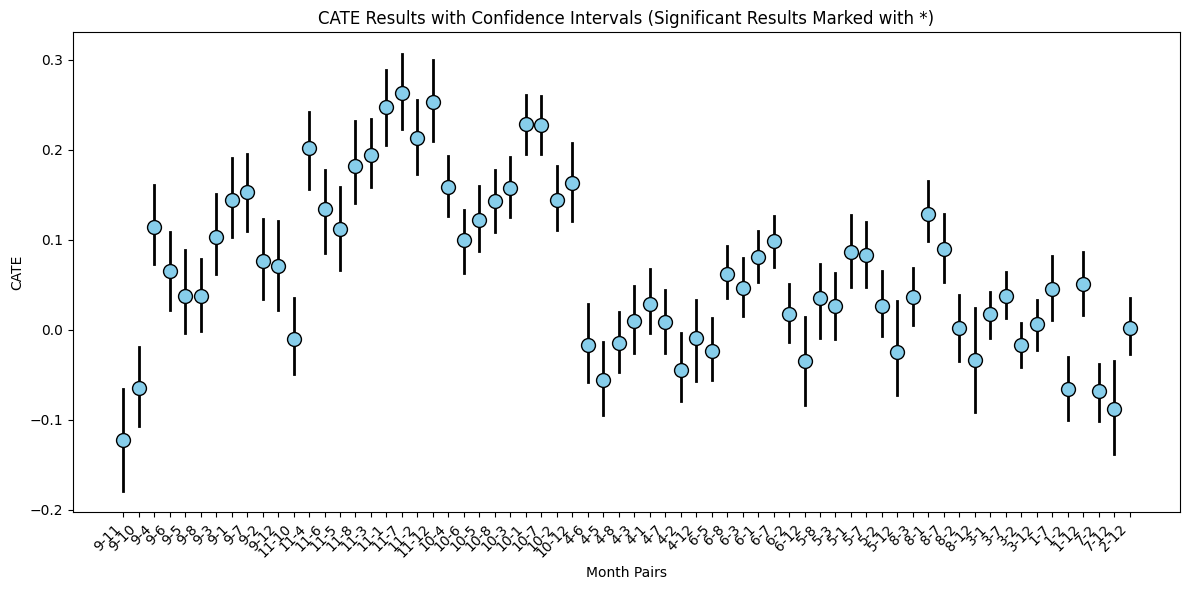

In [61]:
plot_cate_results(cate_results, cate_conf_intervals, p_values)

In [114]:
src_month = 9
target_month = 8  # Specify the target month (September)
target_sample_index = 0  # Specify the index of the target sample in that month
latex_output = display_closest_matches_for_sample_latex_with_reverse(src_month, target_month, target_sample_index, closest_matches, video_games_df_2)

# Print LaTeX output
if latex_output is not None:
    print(latex_output)


\begin{tabular}{lllllrrrrrrr}
\toprule
Title & Console & 'Genre & Publisher & Developer & Critic Score & Niche Count & NA Temperature & JP Temperature & PAL Temperature & Special Sales Day Count & Days Since Release \\
\midrule
Tekken 2 & PS & Fighting & Namco & Namco & 2.966729 & -0.460846 & 1.308394 & 1.460003 & 1.471036 & -0.609447 & 1.921876 \\
Batman: Arkham Asylum & PS3 & Action & Eidos Interactive & Rocksteady Studios & 2.818258 & -0.564638 & 1.363048 & 1.464901 & 1.545308 & -0.609447 & -0.230806 \\
\bottomrule
\end{tabular}



In [115]:
# Convert numpy.int64 keys to int before saving
cate_results = convert_keys_to_int(cate_results)
cate_conf_intervals = convert_keys_to_int(cate_conf_intervals)
p_values = convert_keys_to_int(p_values)

# Save the results to JSON files
with open('cate_results_1nn.json', 'w') as f:
    json.dump(cate_results, f, indent=4)

with open('cate_conf_intervals_1nn.json', 'w') as f:
    json.dump(cate_conf_intervals, f, indent=4)
    
with open('p_values_1nn.json', 'w') as f:
    json.dump(p_values, f, indent=4)

## Three Neighbors

In [121]:
closest_matches = find_closest_matches_with_sales(video_games_df, k=3)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


In [104]:
cate_dict = cate(closest_matches, video_games_df['month'].unique())
cate_intervals = bootstrap_cate_with_p_value(closest_matches, video_games_df['month'].unique(), num_bootstrap=500)
cate_results, cate_conf_intervals, p_values = cate_intervals
print_ates(cate_dict)

100%|██████████| 1/1 [00:07<00:00,  7.78s/it]

ATE from 9 to 11: -0.5457860159549508
ATE from 9 to 10: -0.3867292351008916
ATE from 9 to 4: -0.06029094321914594
ATE from 9 to 6: -0.10043172219615204
ATE from 9 to 5: -0.13671984983575788
ATE from 9 to 8: -0.20072735804786485
ATE from 9 to 3: -0.07419990614734868
ATE from 9 to 1: 0.025424683247301766
ATE from 9 to 7: 0.03292351008916
ATE from 9 to 2: -0.04738620366025341
ATE from 9 to 12: 0.03534021586109805
ATE from 11 to 10: -0.3140689886135298
ATE from 11 to 4: 0.011784996651038196
ATE from 11 to 6: -0.018405894172806424
ATE from 11 to 5: -0.09935030140656399
ATE from 11 to 8: 0.013318821165438746
ATE from 11 to 3: 0.03240455458807767
ATE from 11 to 1: 0.11770261219022105
ATE from 11 to 7: 0.2064969859343604
ATE from 11 to 2: 0.056091761553918325
ATE from 11 to 12: 0.12271265907568654
ATE from 10 to 4: -0.052087756546355286
ATE from 10 to 6: -0.040679405520169826
ATE from 10 to 5: -0.11764331210191084
ATE from 10 to 8: -0.04914366595895262
ATE from 10 to 3: -0.016949752300070762
A

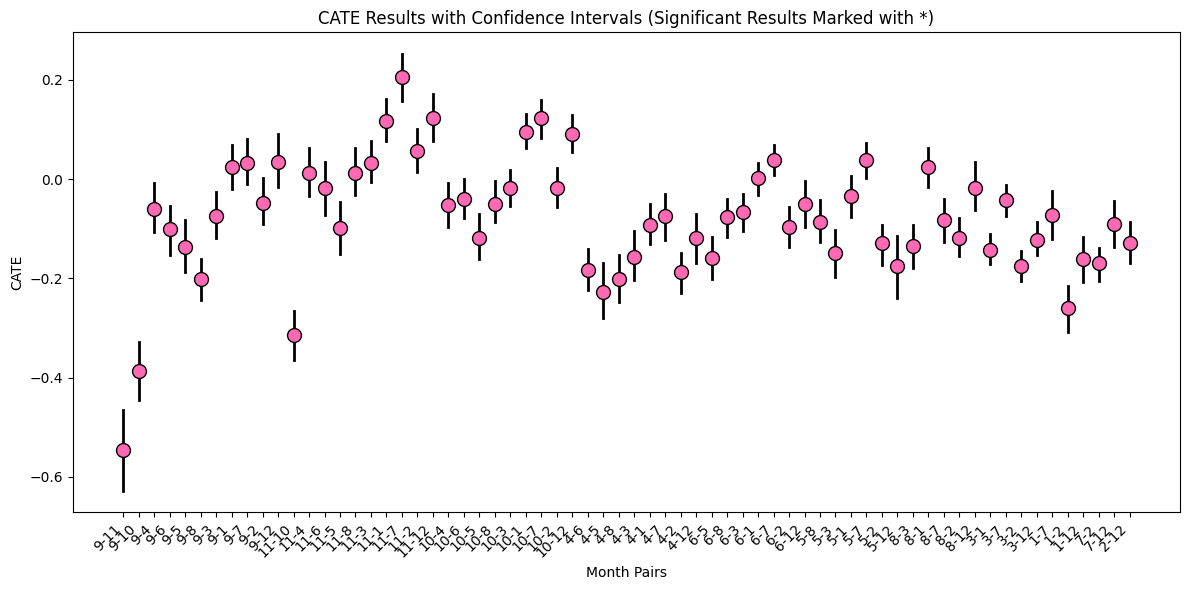

In [67]:
plot_cate_results(cate_results, cate_conf_intervals, p_values)

In [122]:
src_month = 9
target_month = 8  # Specify the target month (September)
target_sample_index = 0  # Specify the index of the target sample in that month
latex_output = display_closest_matches_for_sample_latex_with_reverse(src_month, target_month, target_sample_index, closest_matches, video_games_df_2)

# Print LaTeX output
if latex_output is not None:
    print(latex_output)

\begin{tabular}{lllllrrrrrrr}
\toprule
Title & Console & 'Genre & Publisher & Developer & Critic Score & Niche Count & NA Temperature & JP Temperature & PAL Temperature & Special Sales Day Count & Days Since Release \\
\midrule
Tekken 2 & PS & Fighting & Namco & Namco & 2.966729 & -0.460846 & 1.308394 & 1.460003 & 1.471036 & -0.609447 & 1.921876 \\
Batman: Arkham Asylum & PS3 & Action & Eidos Interactive & Rocksteady Studios & 2.818258 & -0.564638 & 1.363048 & 1.464901 & 1.545308 & -0.609447 & -0.230806 \\
Deus Ex: Human Revolution & PS3 & Shooter & Square Enix & Eidos Montreal & 2.521315 & -0.460846 & 1.511692 & 1.603822 & 1.193190 & -0.609447 & -0.560872 \\
F1 2017 & XOne & Racing & Deep Silver & Codemasters & 2.818258 & -0.408949 & 1.335684 & 1.595074 & 1.336585 & -0.609447 & -1.555604 \\
\bottomrule
\end{tabular}



In [108]:
# Convert numpy.int64 keys to int before saving
cate_results = convert_keys_to_int(cate_results)
cate_conf_intervals = convert_keys_to_int(cate_conf_intervals)
p_values = convert_keys_to_int(p_values)

# Save the results to JSON files
with open('cate_results_3nn.json', 'w') as f:
    json.dump(cate_results, f, indent=4)

with open('cate_conf_intervals_3nn.json', 'w') as f:
    json.dump(cate_conf_intervals, f, indent=4)
    
with open('p_values.json_3nn', 'w') as f:
    json.dump(p_values, f, indent=4)

## Five Neigbors

In [118]:
closest_matches = find_closest_matches_with_sales(video_games_df, k=5)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


In [119]:
cate_dict = cate(closest_matches, video_games_df['month'].unique())
cate_intervals = bootstrap_cate_with_p_value(closest_matches, video_games_df['month'].unique(), num_bootstrap=500)
cate_results, cate_conf_intervals, p_values = cate_intervals
print_ates(cate_dict)

100%|██████████| 1/1 [00:03<00:00,  3.70s/it]

ATE from 9 to 11: -0.7283904270295637
ATE from 9 to 10: -0.4857578601595495
ATE from 9 to 4: -0.08282496480525577
ATE from 9 to 6: -0.1546644767714688
ATE from 9 to 5: -0.14519943688409195
ATE from 9 to 8: -0.27292351008916
ATE from 9 to 3: -0.10007508212106989
ATE from 9 to 1: -0.0012388549976536773
ATE from 9 to 7: 0.005753167526982633
ATE from 9 to 2: -0.0707320506804317
ATE from 9 to 12: 0.03183951196621303
ATE from 11 to 10: -0.45478566644340246
ATE from 11 to 4: -0.0469256530475553
ATE from 11 to 6: -0.06494641661085068
ATE from 11 to 5: -0.1295579370395177
ATE from 11 to 8: -0.04078365706630942
ATE from 11 to 3: -0.05761219022103149
ATE from 11 to 1: 0.06814467515070333
ATE from 11 to 7: 0.17088412592096452
ATE from 11 to 2: 0.0028600133958472753
ATE from 11 to 12: 0.07403215003348962
ATE from 10 to 4: -0.12211606510969567
ATE from 10 to 6: -0.09416135881104033
ATE from 10 to 5: -0.1987296532200991
ATE from 10 to 8: -0.12053078556263273
ATE from 10 to 3: -0.08178697806086341
ATE

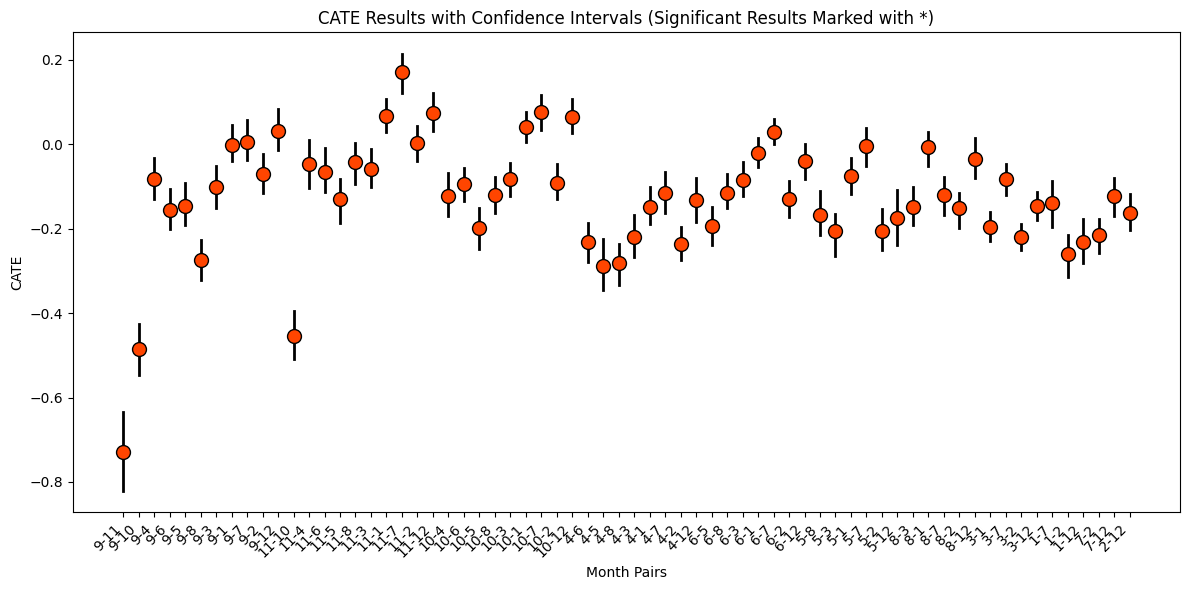

In [71]:
plot_cate_results(cate_results, cate_conf_intervals, p_values)

In [120]:
src_month = 9
target_month = 8  # Specify the target month (September)
target_sample_index = 0  # Specify the index of the target sample in that month
latex_output = display_closest_matches_for_sample_latex_with_reverse(src_month, target_month, target_sample_index, closest_matches, video_games_df_2)

# Print LaTeX output
if latex_output is not None:
    print(latex_output)

\begin{tabular}{lllllrrrrrrr}
\toprule
Title & Console & 'Genre & Publisher & Developer & Critic Score & Niche Count & NA Temperature & JP Temperature & PAL Temperature & Special Sales Day Count & Days Since Release \\
\midrule
Tekken 2 & PS & Fighting & Namco & Namco & 2.966729 & -0.460846 & 1.308394 & 1.460003 & 1.471036 & -0.609447 & 1.921876 \\
Batman: Arkham Asylum & PS3 & Action & Eidos Interactive & Rocksteady Studios & 2.818258 & -0.564638 & 1.363048 & 1.464901 & 1.545308 & -0.609447 & -0.230806 \\
Deus Ex: Human Revolution & PS3 & Shooter & Square Enix & Eidos Montreal & 2.521315 & -0.460846 & 1.511692 & 1.603822 & 1.193190 & -0.609447 & -0.560872 \\
F1 2017 & XOne & Racing & Deep Silver & Codemasters & 2.818258 & -0.408949 & 1.335684 & 1.595074 & 1.336585 & -0.609447 & -1.555604 \\
Batman: Arkham Asylum & X360 & Action & Eidos Interactive & Rocksteady Studios & 2.966729 & -0.305157 & 1.363048 & 1.464901 & 1.545308 & -0.609447 & -0.230806 \\
Metroid Prime: Trilogy & Wii & Shoo

In [123]:
# Convert numpy.int64 keys to int before saving
cate_results = convert_keys_to_int(cate_results)
cate_conf_intervals = convert_keys_to_int(cate_conf_intervals)
p_values = convert_keys_to_int(p_values)

# Save the results to JSON files
with open('cate_results_5nn.json', 'w') as f:
    json.dump(cate_results, f, indent=4)

with open('cate_conf_intervals_5nn.json', 'w') as f:
    json.dump(cate_conf_intervals, f, indent=4)
    
with open('p_values_5nn.json', 'w') as f:
    json.dump(p_values, f, indent=4)

# Propensity Scores

In [28]:
import numpy as np

In [ ]:
# Separate features and target
X = video_games_df.drop(columns=['month', 'total_sales', 'img', 'na_sales', 'jp_sales', 'pal_sales',
       'other_sales', 'release_date', 'last_update', 'iso_year',
       'iso_week', 'year_week', 'title'])
y = video_games_df['month']

# 2. Estimate Propensity Scores
# Fit a multinomial logistic regression for propensity scores
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_model.fit(X, y)
propensity_scores = logistic_model.predict_proba(X)  # Each row has probabilities for each 'month'

# 3. Match Units
# Compute pairwise distances based on propensity scores
# This creates a distance matrix for matching similar propensity scores across months
# distances = pairwise_distances(propensity_scores, metric='euclidean')


In [30]:
# Save propensity scores
np.save("propensity_scores_post_norm.npy", propensity_scores)  # Binary format
np.savetxt("propensity_scores_post_norm.csv", propensity_scores, delimiter=",")  # Text format (optional)

# Save distances
# np.save("distances.npy", distances)  # Binary format
# np.savetxt("distances.csv", distances, delimiter=",")  # Text format (optional)


In [72]:
propensity_scores = np.load("propensity_scores_post_norm.npy")

In [73]:
def find_closest_matches_with_sales_and_propensity(video_games_df, propensity_scores, k=1):
    # Initialize a dictionary to store the closest matches for each unit by month
    closest_matches = {}

    # List of all unique months in the data
    months = video_games_df['month'].unique()

    # Loop over each month to get the current month's units
    for current_month in months:
        current_month_data = video_games_df[video_games_df['month'] == current_month]
        
        # Drop non-feature columns from current month's data
        X_current = current_month_data.drop(columns=['month', 'total_sales', 'img', 'na_sales', 
                                                     'jp_sales', 'pal_sales', 'other_sales', 
                                                     'release_date', 'last_update', 'iso_year', 
                                                     'iso_week', 'year_week', 'title'])
        
        # Add the propensity scores corresponding to the current month
        current_month_indices = current_month_data.index
        propensity_current = propensity_scores[current_month_indices]
        X_current_combined = np.hstack((X_current, propensity_current))
        
        # Initialize a dictionary to hold matches for each unit in the current month
        closest_matches[current_month] = {}

        # Loop over each of the other months
        for other_month in tqdm(months):
            if other_month == current_month:
                continue  # Skip the current month itself
            
            # Get data from the other month
            other_month_data = video_games_df[video_games_df['month'] == other_month]
            X_other = other_month_data.drop(columns=['month', 'total_sales', 'img', 'na_sales', 
                                                     'jp_sales', 'pal_sales', 'other_sales', 
                                                     'release_date', 'last_update', 'iso_year', 
                                                     'iso_week', 'year_week', 'title'])
            
            # Add the propensity scores corresponding to the other month
            other_month_indices = other_month_data.index
            propensity_other = propensity_scores[other_month_indices]
            X_other_combined = np.hstack((X_other, propensity_other))

            # Initialize and fit the KNN model on the other month's data
            knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
            knn.fit(X_other_combined)
            
            # Find k closest matches for each unit in the current month from the other month
            distances, indices = knn.kneighbors(X_current_combined)
            
            # Store the results in the dictionary under the current and other month combination
            closest_matches[current_month][other_month] = {
                "distances": distances,
                "indices": indices,
                "matches": other_month_data.iloc[indices.flatten()],
                "current_sales": current_month_data['total_sales'].values,  # Sales of current month units
                "matched_sales": other_month_data['total_sales'].iloc[indices.flatten()].values  # Sales of matched units
            }
    
    return closest_matches

In [124]:
matches = find_closest_matches_with_sales_and_propensity(video_games_df, propensity_scores)

100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


In [77]:
cate_dict = cate(matches, video_games_df['month'].unique())
cate_intervals = bootstrap_cate_with_p_value(matches, video_games_df['month'].unique(), num_bootstrap=500)
cate_results, cate_conf_intervals, p_values = cate_intervals
print_ates(cate_dict)

100%|██████████| 1/1 [00:07<00:00,  7.68s/it]

ATE from 9 to 11: -0.12412482402627874
ATE from 9 to 10: -0.05581886438291881
ATE from 9 to 4: 0.10480056311590805
ATE from 9 to 6: 0.06235570154856877
ATE from 9 to 5: 0.037137494134209297
ATE from 9 to 8: 0.039572970436414834
ATE from 9 to 3: 0.10129985922102301
ATE from 9 to 1: 0.14381980290943217
ATE from 9 to 7: 0.16824495541999063
ATE from 9 to 2: 0.07807602064758327
ATE from 9 to 12: 0.0924730173627405
ATE from 11 to 10: -0.017052913596785003
ATE from 11 to 4: 0.18952444742129934
ATE from 11 to 6: 0.12989953114534497
ATE from 11 to 5: 0.10560281312793032
ATE from 11 to 8: 0.18317481580709977
ATE from 11 to 3: 0.19560951105157406
ATE from 11 to 1: 0.24921299397186866
ATE from 11 to 7: 0.280324849296718
ATE from 11 to 2: 0.21405559276624245
ATE from 11 to 12: 0.25400870730073677
ATE from 10 to 4: 0.1364897381457891
ATE from 10 to 6: 0.11456475583864119
ATE from 10 to 5: 0.12066525123849961
ATE from 10 to 8: 0.14735314932767166
ATE from 10 to 3: 0.16195682944090586
ATE from 10 to 1

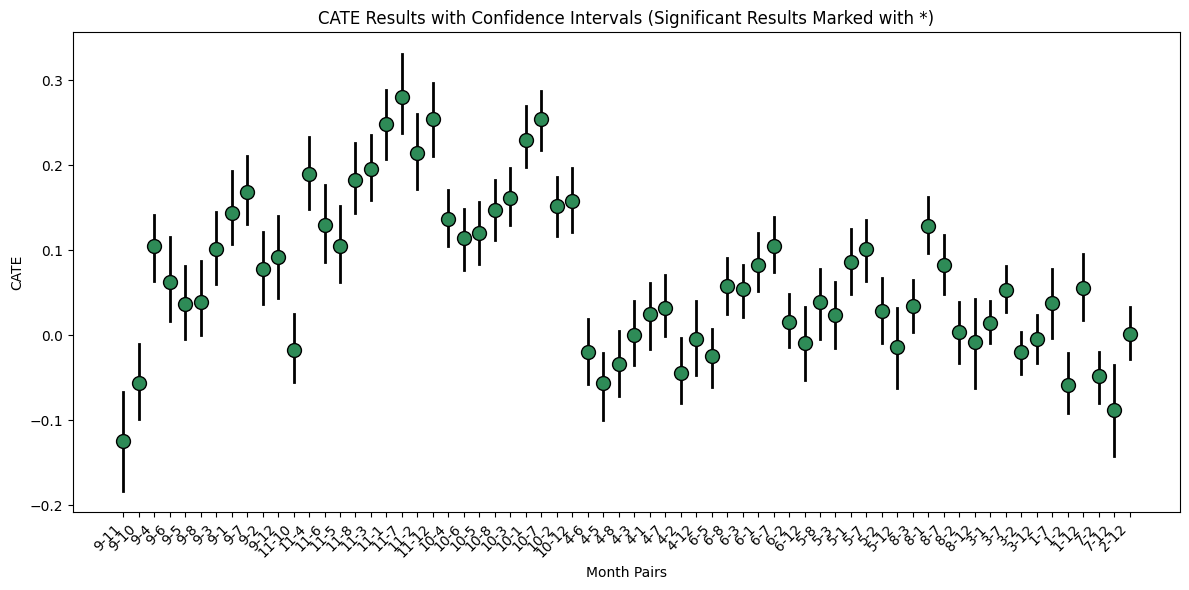

In [78]:
plot_cate_results(cate_results, cate_conf_intervals, p_values)

In [125]:
src_month = 9
target_month = 8  # Specify the target month (September)
target_sample_index = 0  # Specify the index of the target sample in that month
latex_output = display_closest_matches_for_sample_latex_with_reverse(src_month, target_month, target_sample_index, closest_matches, video_games_df_2)

# Print LaTeX output
if latex_output is not None:
    print(latex_output)

\begin{tabular}{lllllrrrrrrr}
\toprule
Title & Console & 'Genre & Publisher & Developer & Critic Score & Niche Count & NA Temperature & JP Temperature & PAL Temperature & Special Sales Day Count & Days Since Release \\
\midrule
Tekken 2 & PS & Fighting & Namco & Namco & 2.966729 & -0.460846 & 1.308394 & 1.460003 & 1.471036 & -0.609447 & 1.921876 \\
Batman: Arkham Asylum & PS3 & Action & Eidos Interactive & Rocksteady Studios & 2.818258 & -0.564638 & 1.363048 & 1.464901 & 1.545308 & -0.609447 & -0.230806 \\
Deus Ex: Human Revolution & PS3 & Shooter & Square Enix & Eidos Montreal & 2.521315 & -0.460846 & 1.511692 & 1.603822 & 1.193190 & -0.609447 & -0.560872 \\
F1 2017 & XOne & Racing & Deep Silver & Codemasters & 2.818258 & -0.408949 & 1.335684 & 1.595074 & 1.336585 & -0.609447 & -1.555604 \\
\bottomrule
\end{tabular}



In [ ]:
# Convert numpy.int64 keys to int before saving
cate_results = convert_keys_to_int(cate_results)
cate_conf_intervals = convert_keys_to_int(cate_conf_intervals)
p_values = convert_keys_to_int(p_values)

# Save the results to JSON files
with open('cate_results_prop.json', 'w') as f:
    json.dump(cate_results, f, indent=4)

with open('cate_conf_intervals_prop.json', 'w') as f:
    json.dump(cate_conf_intervals, f, indent=4)
    
with open('p_values.json_prop', 'w') as f:
    json.dump(p_values, f, indent=4)